<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-PyTorch/blob/main/pytorch_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.13.1+cu116'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Load and normalize the dataset

In [6]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/tongpython/cat-and-dog'
od.download(dataset_url)

100%|██████████| 218M/218M [00:01<00:00, 116MB/s]


In [7]:
image_path = "/content/cat-and-dog"
train_dir = f"{image_path}/training_set/training_set"
test_dir = f"{image_path}/test_set/test_set"

In [24]:
from torchvision import transforms

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [25]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets

# Turn image folders into Datasets
train_data= datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Random image path: /content/cat-and-dog/training_set/training_set/dogs/dog.2413.jpg
Image class: dogs
Image height: 500
Image width: 374


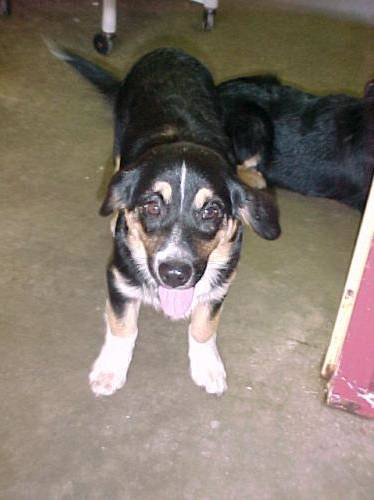

In [26]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

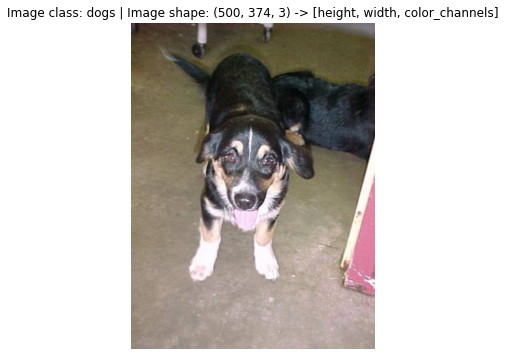

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 2. Define a Convolutional Neural Network

In [41]:
class ImageClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2)) 
        self.classifier = nn.Sequential(
          nn.Flatten(),
           nn.Linear(in_features=512*3*3, out_features=2)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
model = ImageClassifier().to(device)

In [36]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT]) # do a test pass through of an example input size 

<function torchinfo.torchinfo.summary(model: 'nn.Module', input_size: 'INPUT_SIZE_TYPE | None' = None, input_data: 'INPUT_DATA_TYPE | None' = None, batch_dim: 'int | None' = None, cache_forward_pass: 'bool | None' = None, col_names: 'Iterable[str] | None' = None, col_width: 'int' = 25, depth: 'int' = 3, device: 'torch.device | str | None' = None, dtypes: 'list[torch.dtype] | None' = None, mode: 'str | None' = None, row_settings: 'Iterable[str] | None' = None, verbose: 'int | None' = None, **kwargs: 'Any') -> 'ModelStatistics'>

In [40]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 3, 3])
Output logits:
tensor([[ 0.0013, -0.0104]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5029, 0.4971]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
1


# 3. Define a Loss function and optimizer

In [42]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

# 4. Create train & test loop functions

In [43]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0  
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [44]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()  
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0  
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))       
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Now let's create a train() function to combine train_step() and test_step().

In [45]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):   
    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}   
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}" )
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# 5. Train and Evaluate Model

In [46]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6932 | train_acc: 0.6327 | test_loss: 0.5575 | test_acc: 0.7084
Epoch: 2 | train_loss: 0.5980 | train_acc: 0.6939 | test_loss: 0.5623 | test_acc: 0.7121
Epoch: 3 | train_loss: 0.5453 | train_acc: 0.7300 | test_loss: 0.6091 | test_acc: 0.7067
Epoch: 4 | train_loss: 0.5053 | train_acc: 0.7543 | test_loss: 0.6465 | test_acc: 0.7042
Epoch: 5 | train_loss: 0.4493 | train_acc: 0.7856 | test_loss: 0.4130 | test_acc: 0.8041
Epoch: 6 | train_loss: 0.4188 | train_acc: 0.7997 | test_loss: 0.4753 | test_acc: 0.7863
Epoch: 7 | train_loss: 0.3782 | train_acc: 0.8279 | test_loss: 0.3722 | test_acc: 0.8312
Epoch: 8 | train_loss: 0.3495 | train_acc: 0.8396 | test_loss: 0.3882 | test_acc: 0.8297
Epoch: 9 | train_loss: 0.3079 | train_acc: 0.8583 | test_loss: 0.3034 | test_acc: 0.8747
Epoch: 10 | train_loss: 0.2845 | train_acc: 0.8723 | test_loss: 0.2765 | test_acc: 0.8793
Epoch: 11 | train_loss: 0.2545 | train_acc: 0.8840 | test_loss: 0.2746 | test_acc: 0.8842
Epoch: 12 | train_l

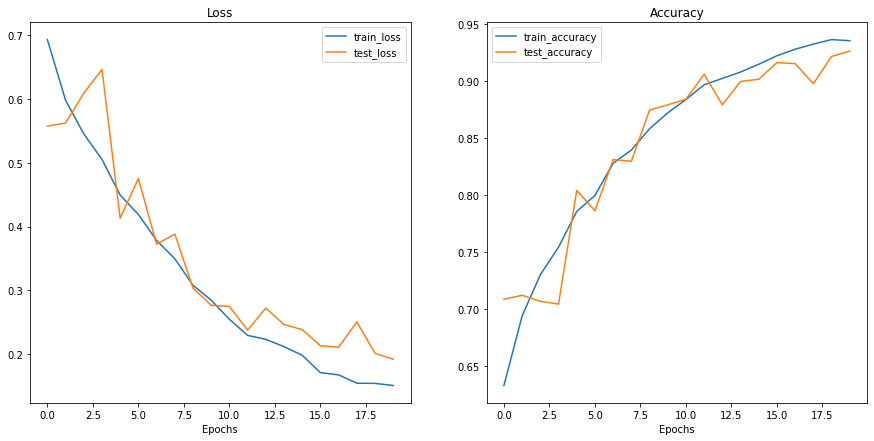

In [47]:
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_curves(model_results)

In [48]:
PATH = './image_classifier-2.pth'
torch.save(ImageClassifier().state_dict(), PATH)

In [49]:
model = ImageClassifier()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Building An App with Gradio

In [51]:
image_transform = transforms.Compose([
      transforms.Resize(size=(224,224)),
      transforms.ToTensor()
])
labels = train_data.classes
def predict(inp):
  image_transformed = image_transform(inp)
  with torch.no_grad():
    prediction = torch.nn.functional.softmax(model(image_transformed.unsqueeze(dim=0).to(device)))
    confidences = {labels[i]: float(prediction[i]) for i in range(len(labels))}    
  return confidences

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
gr.Interface(fn=predict, 
             inputs=gr.Image(),
             outputs=gr.Label(num_top_classes=2),
             examples=['cat.jpg', 'dog.jpg']).launch()

- Thanks for reading
- Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) |[GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎